In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import yfinance as yf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Lambda, SimpleRNN, LSTM

In [2]:
def evaluate_model(model, X_val, y_val):
    forecast_val = model.predict(X_val)
    mae_val = mean_absolute_error(y_val, forecast_val)
    mse_val = mean_squared_error(y_val, forecast_val)
    return mae_val, mse_val

def plot_predictions(forecast_val, y_val, title="Baseline model plot"):
    plt.figure(figsize=(10, 6))
    plt.plot(forecast_val, label='Predicted Validation')
    plt.plot(y_val, label='Actual Validation')
    plt.title(title)
    plt.legend()
    plt.show()

In [3]:
# 1. Load the Apple closing stock price from Yahoo Finance
tickerSymbol = 'AAPL'
df = yf.Ticker(tickerSymbol)
df = df.history(period='1d', start='2013-01-01', end='2023-01-01')


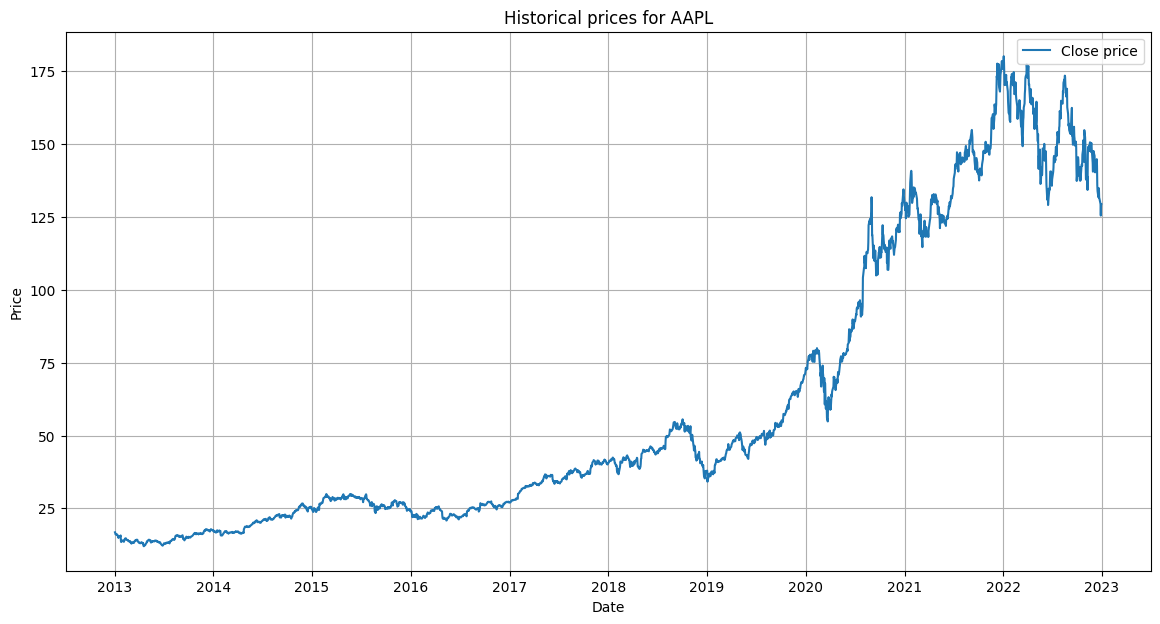

In [4]:
plt.figure(figsize=(14,7))
plt.plot(df.index, df['Close'], label='Close price')
plt.title('Historical prices for AAPL')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()


In [6]:
data = df['Close'].values

# Sliding window
window_size = 20
X, y = [], []
for i in range(window_size, len(data)):
    X.append(data[i-window_size:i])
    y.append(data[i])

X = np.array(X)
y = np.array(y)

# Train/val split
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Dataset using tf.data
batch_size = 128
buffer_size = 1000

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

#DNN

In [7]:
# Model
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(window_size,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Fit model
history = model.fit(train_data, epochs=100, verbose=0)

16/16 [==============================] - 1s 4ms/step


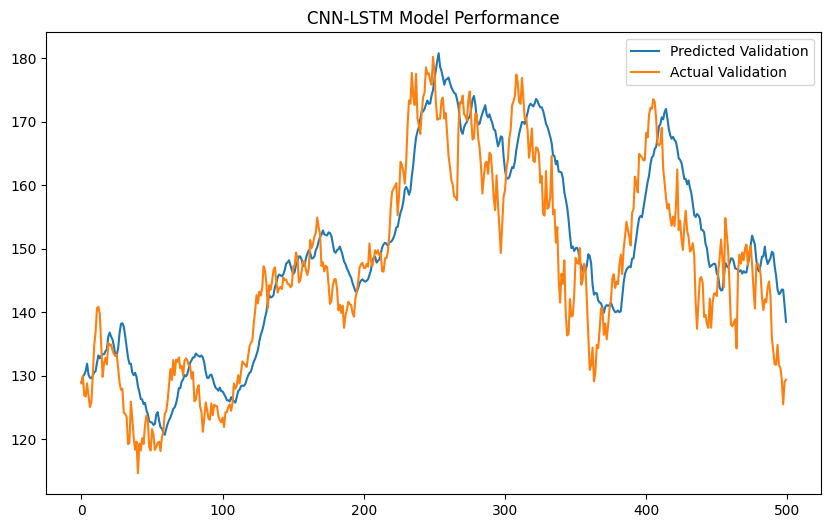

16/16 [==============================] - 0s 10ms/step
MAE: 6.021060409545899, MSE: 55.29950353753462


In [8]:
# plot
forecast = model.predict(X_val)
plot_predictions(forecast, y_val, title="CNN-LSTM Model Performance")
# evaluate
mae, mse = evaluate_model(model, X_val, y_val)
print(f'MAE: {mae}, MSE: {mse}')



#CNN

In [9]:
# Reshape data for CNN, RNN, LSTM, CNN-LSTM
X_train = X_train.reshape(-1, window_size, 1)
X_val = X_val.reshape(-1, window_size, 1)
# Dataset using tf.data
batch_size = 128
buffer_size = 1000

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Build CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=8e-4), loss='mse')

# Train model
model.fit(train_data, epochs=100, verbose=0)

16/16 [==============================] - 0s 2ms/step


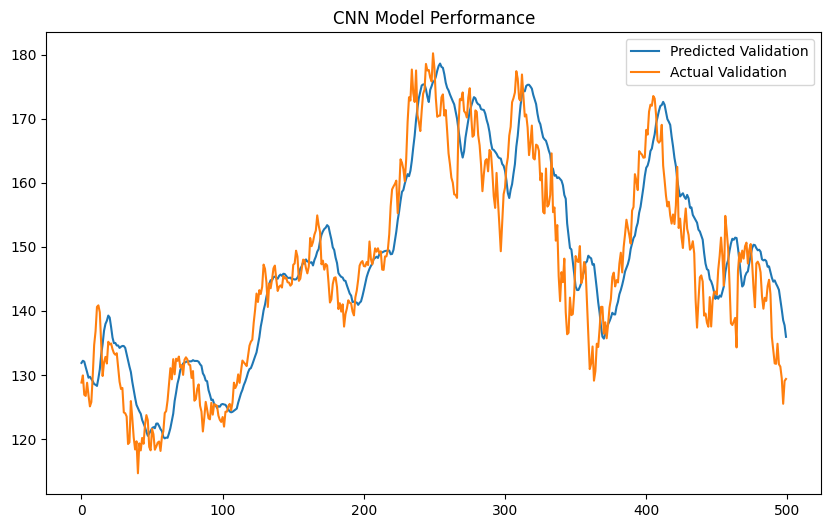

16/16 [==============================] - 0s 2ms/step
MAE: 5.350092239379883, MSE: 44.036669906677794


In [10]:
# plot
forecast = model.predict(X_val)
plot_predictions(forecast, y_val, title="CNN Model Performance")
# evaluate
mae, mse = evaluate_model(model, X_val, y_val)
print(f'MAE: {mae}, MSE: {mse}')



#RNN

In [11]:
# Build RNN model
model = Sequential()
model.add(SimpleRNN(64, activation='relu', return_sequences=True, input_shape=(window_size, 1)))
model.add(SimpleRNN(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Fit model
model.fit(train_data, epochs=100, verbose=0)

16/16 [==============================] - 0s 5ms/step


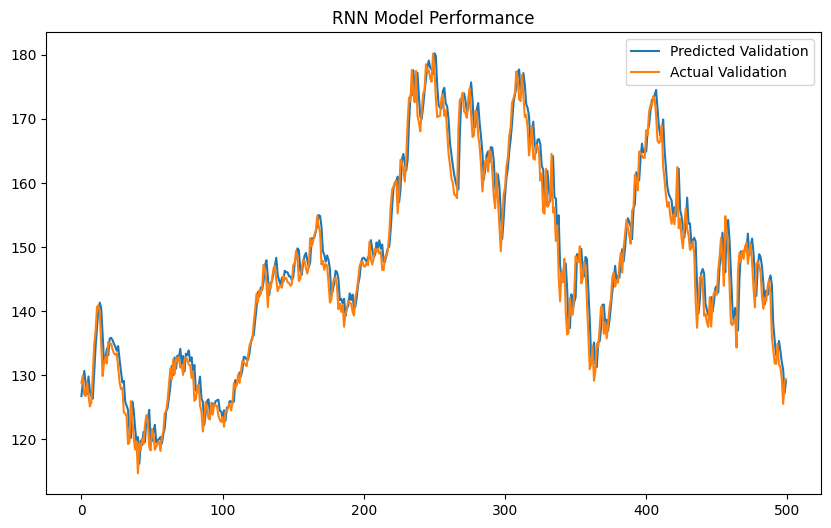

16/16 [==============================] - 0s 4ms/step
MAE: 2.3694234161376952, MSE: 9.43911951329105


In [12]:
# plot
forecast = model.predict(X_val)
plot_predictions(forecast, y_val, title="RNN Model Performance")
# evaluate
mae, mse = evaluate_model(model, X_val, y_val)
print(f'MAE: {mae}, MSE: {mse}')


#LSTM

In [13]:
# Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

# Train model
model.fit(train_data, epochs=100, verbose=0)

16/16 [==============================] - 0s 4ms/step


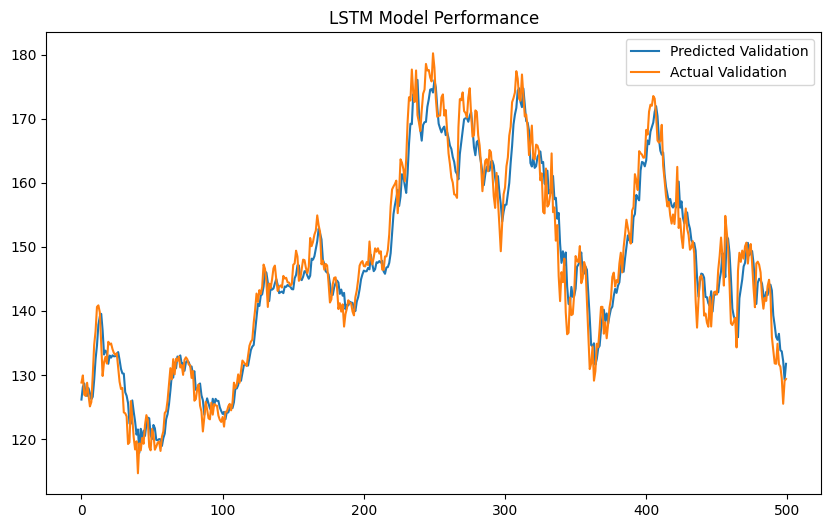

16/16 [==============================] - 0s 6ms/step
MAE: 2.6104147033691407, MSE: 11.290272585817148


In [14]:
# plot
forecast = model.predict(X_val)
plot_predictions(forecast, y_val, title="LSTM Model Performance")
# evaluate
mae, mse = evaluate_model(model, X_val, y_val)
print(f'MAE: {mae}, MSE: {mse}')


#CNN-LSTM

In [15]:
# Model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation="relu", input_shape=[window_size, 1]),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(30, activation="relu"),
    Dense(10, activation="relu"),
    Dense(1)
])

# Compile model with optimizer and loss
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

# Fit model
history = model.fit(train_data, epochs=100, verbose=0)

16/16 [==============================] - 1s 10ms/step


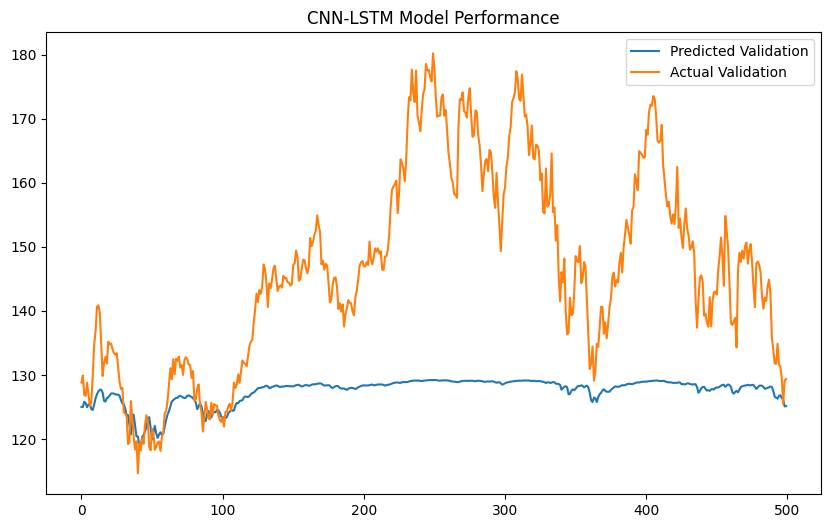

16/16 [==============================] - 0s 10ms/step
MAE: 19.324587463378908, MSE: 558.2478915074172


In [16]:
# plot
forecast = model.predict(X_val)
plot_predictions(forecast, y_val, title="CNN-LSTM Model Performance")
# evaluate
mae, mse = evaluate_model(model, X_val, y_val)
print(f'MAE: {mae}, MSE: {mse}')
